# Введение в torch

In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

import torch

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

/Users/bobazooba/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

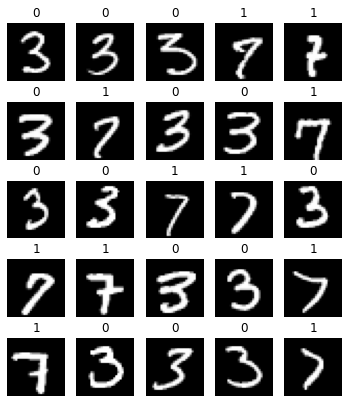

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [7]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Либо так

In [8]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [9]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self, in_features, inner_features, out_features):
        
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        
        return x
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [10]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [11]:
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [12]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [13]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.BCELoss()

In [14]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [15]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[ 0.0145, -0.0216,  0.0109,  ...,  0.0296, -0.0126,  0.0122],
         [-0.0332,  0.0219, -0.0287,  ..., -0.0222, -0.0106,  0.0294],
         [ 0.0231, -0.0329,  0.0002,  ..., -0.0297,  0.0315,  0.0324],
         ...,
         [-0.0315,  0.0279,  0.0336,  ...,  0.0259,  0.0098, -0.0082],
         [-0.0065, -0.0318, -0.0222,  ..., -0.0339, -0.0328,  0.0025],
         [-0.0213,  0.0315,  0.0204,  ..., -0.0069, -0.0279,  0.0024]],
        requires_grad=True),
 Parameter containing:
 tensor([ 1.6150e-02,  3.1855e-02,  2.4850e-02, -3.2633e-03, -3.4994e-02,
         -2.3166e-02,  6.7476e-03, -2.5939e-02,  7.2354e-03, -1.7827e-02,
          1.8702e-02, -3.5713e-02,  7.0094e-03, -7.5102e-04, -2.9308e-02,
          2.9857e-02, -1.7982e-02, -1.1262e-02, -4.8488e-03, -3.2002e-02,
         -4.3904e-03,  2.7694e-02,  9.3303e-03,  3.6537e-03, -2.7550e-02,
         -2.6065e-02,  5.4980e-03, -3.4676e-02,  1.7932e-02, -4.6961e-03,
         -3.5074e-02,  5.5640e-03, -3.11

# Обучим нашу модель

In [16]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука отдает нам батчи данных
# мы поговорим больше про нее позже в курсе
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    # 
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    # 
    optimizer.zero_grad()
    
    # 
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    # 
    # торч строит граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    # 
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили relu
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    # 
    pred = model(x)
    
    # 
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    # 
    loss = criterion(pred, y.float())
    
    # 
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    # 
    # то есть это почти то же самое, что мы делали в домашке с классами
    # 
    loss.backward()
    
    # 
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    # 
    optimizer.step()
    
    # 
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    # 
    # для тензоров работает метод .tolist()
    # 
    current_loss_value = loss.item()
    losses.append(loss.item())

In [17]:
# Одна эпоха прошла

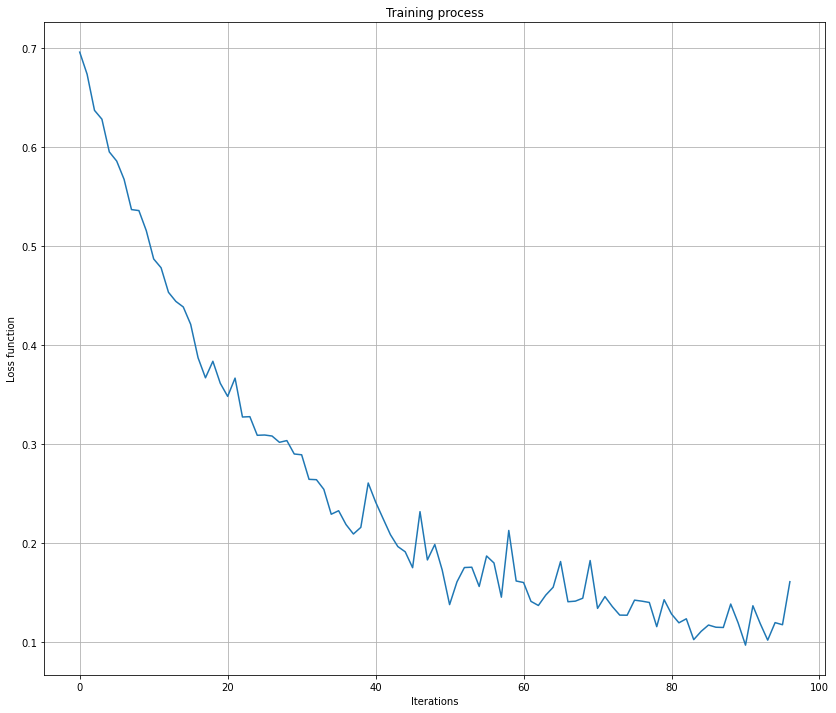

In [18]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [19]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [20]:
x.shape

torch.Size([128, 784])

In [21]:
y.shape

torch.Size([128, 1])

In [22]:
# переходим в режим предсказания
# 
# позже в курсе мы разберем зачем конкретно это нужно
# некоторые детали:
# дропаут больше не зануляет часть значений, 
# батч норм больше не нормирует каждый батч, а использует накопленную статистику при обучении и тд
# 
model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [23]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
# нам сейчас нужен только forward проход
# мы не собираемся обновлять веса
with torch.no_grad():

    pred = model(x)

In [24]:
pred.shape

torch.Size([128, 1])

In [25]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [26]:
pred.shape

torch.Size([128])

In [27]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [28]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [29]:
type(y)

numpy.ndarray

In [30]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [31]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.9609375

In [32]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
# но вообще это тот же SGD, но с некоторыми хаками
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [33]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    # early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    

Epoch 2:   6%|▌         | 768/12396 [00:00<00:02, 4365.85it/s, train_loss=0.0485]

Losses: train - 0.064, test = 0.042
Test: accuracy - 0.985


Epoch 3:   7%|▋         | 896/12396 [00:00<00:01, 5846.46it/s, train_loss=0.0245]

Losses: train - 0.026, test = 0.033
Test: accuracy - 0.991


Epoch 4:   7%|▋         | 896/12396 [00:00<00:02, 5168.42it/s, train_loss=0.0141]

Losses: train - 0.015, test = 0.020
Test: accuracy - 0.993


Epoch 4: 100%|██████████| 12396/12396 [00:02<00:00, 5877.34it/s, train_loss=0.00982]


Losses: train - 0.010, test = 0.022
Test: accuracy - 0.993
Early stopping


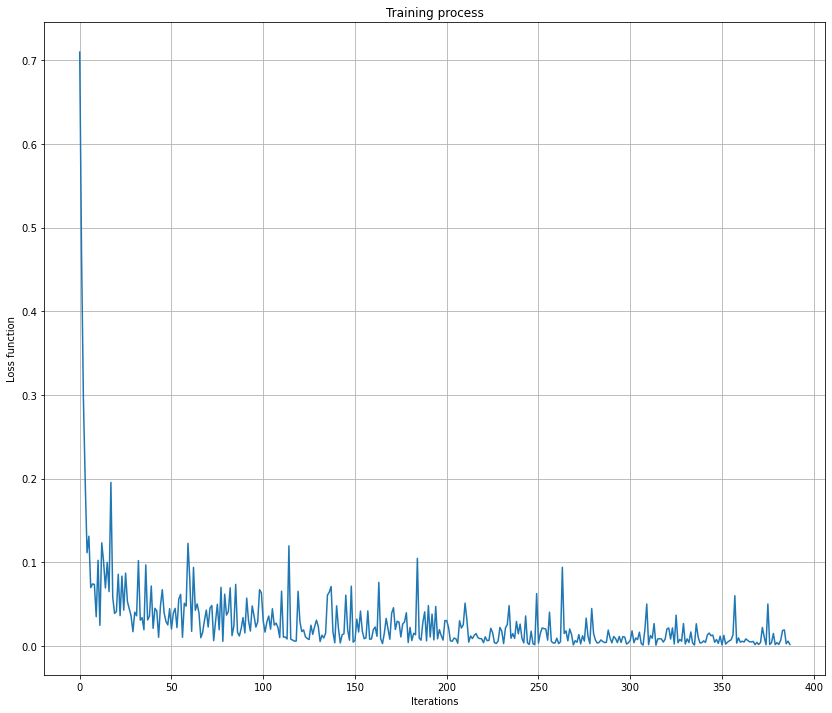

In [34]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# One more deeper
## Пойдем глубже раскрывать суть лего в глубоком обучении
Атомарной частью торча является ```torch.nn.Parameter``` - обучаемый вес.  
По сути это такой же тензор, но только мы говорим торчу, что мы хотим, чтобы торч сохранял градиент для этого веса, 
чтобы обновить его при градиентном шаге оптимизатора

```torch.nn.Parameter(data=None, requires_grad=True)```  
В дефолтном варианте для тензора мы не требуем сохранять градиент, но можем потребовать и тогда наш тензор станет обучаемым весом  
```tensor(data, dtype=None, device=None, requires_grad=False)```

In [35]:
parampampam = torch.nn.Parameter(torch.rand(50))
parampampam

Parameter containing:
tensor([0.7342, 0.8849, 0.3019, 0.1648, 0.4465, 0.8658, 0.5627, 0.7905, 0.1017,
        0.9085, 0.3798, 0.4118, 0.5204, 0.2906, 0.2410, 0.9253, 0.6431, 0.4687,
        0.8773, 0.2452, 0.8743, 0.8294, 0.9562, 0.2782, 0.2181, 0.4884, 0.2344,
        0.5957, 0.1507, 0.0697, 0.3099, 0.6499, 0.9078, 0.4172, 0.4225, 0.8076,
        0.1629, 0.2547, 0.8149, 0.0939, 0.7576, 0.6596, 0.2755, 0.3015, 0.7385,
        0.4451, 0.7071, 0.8217, 0.1541, 0.7524], requires_grad=True)

In [36]:
x = torch.rand(32, 50)

In [37]:
result = parampampam - x

In [38]:
result

tensor([[ 0.6301,  0.2763, -0.4110,  ...,  0.5835, -0.1419,  0.6848],
        [-0.2533,  0.8030, -0.6033,  ...,  0.3672, -0.6476,  0.2370],
        [-0.0782,  0.0849, -0.5517,  ...,  0.3523, -0.1530, -0.2053],
        ...,
        [ 0.4981,  0.5589, -0.2720,  ...,  0.4601, -0.7393,  0.5975],
        [ 0.5658,  0.6773, -0.5167,  ...,  0.4234, -0.4328, -0.1349],
        [ 0.7074,  0.6341,  0.2738,  ...,  0.1545, -0.5257,  0.1724]],
       grad_fn=<SubBackward0>)

### Можно заметить, что у тензора result теперь есть атрибут grad_fn
Это функция, по которой нужно рассчитывать градиент  
И это говорит о том, что теперь у нас есть граф вычислений

In [39]:
result.grad_fn

### И мы можем продолжать наш граф

In [40]:
result_end = torch.sigmoid(result)

In [41]:
result_end

tensor([[0.6525, 0.5686, 0.3987,  ..., 0.6419, 0.4646, 0.6648],
        [0.4370, 0.6906, 0.3536,  ..., 0.5908, 0.3435, 0.5590],
        [0.4804, 0.5212, 0.3655,  ..., 0.5872, 0.4618, 0.4488],
        ...,
        [0.6220, 0.6362, 0.4324,  ..., 0.6130, 0.3232, 0.6451],
        [0.6378, 0.6631, 0.3736,  ..., 0.6043, 0.3935, 0.4663],
        [0.6698, 0.6534, 0.5680,  ..., 0.5386, 0.3715, 0.5430]],
       grad_fn=<SigmoidBackward>)

### Для примера того, когда у нас граф не строится
Когда нам нечего оптимизировать!

In [42]:
z = torch.rand(50)

In [43]:
result_2 = torch.sigmoid(z - x)

In [44]:
result_2

tensor([[0.6608, 0.5240, 0.5487,  ..., 0.4485, 0.5694, 0.5182],
        [0.4460, 0.6509, 0.5008,  ..., 0.3958, 0.4437, 0.4073],
        [0.4896, 0.4762, 0.5137,  ..., 0.3923, 0.5667, 0.3063],
        ...,
        [0.6306, 0.5936, 0.5829,  ..., 0.4182, 0.4212, 0.4964],
        [0.6462, 0.6218, 0.5224,  ..., 0.4093, 0.4971, 0.3215],
        [0.6779, 0.6116, 0.7069,  ..., 0.3463, 0.4739, 0.3918]])

In [45]:
# нет ссылки на функцию, по которой можем рассчитать градиент
print(result_2.grad_fn)

None


# Обучаемые веса
## Теперь мы знаем, что можем сами задавать веса
Так давайте сделаем свой класс для линейного преобразования

In [46]:
class MyLinear(torch.nn.Module):
    
    def __init__(self, in_features, out_features):
        
        super().__init__()
        
        # задаем матрицу весов и смещение
        self.weight = torch.nn.Parameter(torch.rand(in_features, out_features) * 0.01)
        self.bias = torch.nn.Parameter(torch.zeros(out_features))
        
    def forward(self, x):
        
        return torch.matmul(x, self.weight) + self.bias

## Вот таким образом можно написать свои функции и то, как их дифференцировать
На практике встречается супер редко

In [47]:
class MyReLU(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x):

        ctx.save_for_backward(x)
        
        return x.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):

        x, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[x < 0] = 0
        
        return grad_input

In [48]:
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, out_features):
        
        super().__init__()
        
        # слои определяются также как обычно
        self.linear_1 = MyLinear(in_features=in_features, out_features=inner_features)
        # обратите внимание как определяется своя функция
        self.non_linear = MyReLU.apply
        self.linear_2 = MyLinear(in_features=inner_features, out_features=out_features)
        # еще один момент:
        # мы сознательно не определяем сигмоиду
        # 
        # Почему?
        # В торче для NLL и Binary Cross Entropy 
        # есть более оптимальные слои, которые используют некоторые оптимизационные трюки
        # 
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = self.non_linear(x)
        x = self.linear_2(x)
        
        return x

In [49]:
model = MLP(784, 256, 1)

In [50]:
model

MLP(
  (linear_1): MyLinear()
  (linear_2): MyLinear()
)

In [51]:
# вот оптимизация для BCE 
# эта функция потерь объединяет в себе сигмоиду и BCE
# и решает задачу более эффективно

# 
# Для NLLLoss есть это CrossEntropy: https://pytorch.org/docs/stable/nn.html#crossentropyloss
# 
# 
criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model.parameters())

In [52]:
# определим функцию для сигмоиды, чтобы использовать при тестировании
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [53]:
epochs = 10
losses = []
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), np.mean(test_losses)))
    
    test_preds = np.concatenate(test_preds)
    # Применяем сигмоиду
    test_preds = sigmoid(test_preds.squeeze())
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    if np.mean(test_losses) < best_test_loss:
        best_test_loss = np.mean(test_losses)
    else:
        print('Early stopped')
        break    

Epoch 2:   7%|▋         | 896/12396 [00:00<00:01, 5751.20it/s, train_loss=0.141]

Losses: train - 0.179, test = 0.060
Test: accuracy - 0.980


Epoch 3:   7%|▋         | 896/12396 [00:00<00:01, 5936.15it/s, train_loss=0.0407]

Losses: train - 0.040, test = 0.046
Test: accuracy - 0.983


Epoch 4:   8%|▊         | 1024/12396 [00:00<00:01, 6091.17it/s, train_loss=0.0279]

Losses: train - 0.030, test = 0.038
Test: accuracy - 0.987


Epoch 5:   7%|▋         | 896/12396 [00:00<00:01, 6218.97it/s, train_loss=0.0232]

Losses: train - 0.023, test = 0.036
Test: accuracy - 0.989


Epoch 6:   8%|▊         | 1024/12396 [00:00<00:01, 6208.11it/s, train_loss=0.0165]

Losses: train - 0.017, test = 0.031
Test: accuracy - 0.992


Epoch 7:   8%|▊         | 1024/12396 [00:00<00:02, 5662.61it/s, train_loss=0.0134]

Losses: train - 0.013, test = 0.024
Test: accuracy - 0.993


Epoch 8:   8%|▊         | 1024/12396 [00:00<00:02, 5507.93it/s, train_loss=0.00988]

Losses: train - 0.010, test = 0.023
Test: accuracy - 0.993


Epoch 8: 100%|██████████| 12396/12396 [00:02<00:00, 5279.21it/s, train_loss=0.00829]


Losses: train - 0.008, test = 0.026
Test: accuracy - 0.992
Early stopped
